# Importações que são essenciais

In [30]:
#Carregar informações de senha e login
%run "dataLogin.ipynb"
import pandas as pd
import matplotlib.pyplot as plt
import climateservaccess as ca
import json
import ipywidgets as widgets
import pyperclip
import geopandas as gpd
from shapely.geometry import Polygon
import folium
import datetime
import numpy as np
import os
import requests
import time
import rasterio
import rasterio.plot

# Definindo os parametros

In [31]:
_res = 15 # tamanho da região a ser analizada
user = _user
password = _password
_posMaps = [-8.708, -41.298]
_ano_inicial = 2001
_ano_final = 2023
#_NomeLocal = "Glória - BA"
inDir = 'cache_data'  
api = 'https://appeears.earthdatacloud.nasa.gov/api/'  
if not os.path.exists(inDir):
    os.makedirs(inDir)
_localdataName = f"{inDir}/{_posMaps[0]} {_posMaps[1]} {_res}"
if not os.path.exists(_localdataName):
    os.makedirs(_localdataName)
_graficos = _localdataName + "/resultados/"
if not os.path.exists(_graficos):
    os.makedirs(_graficos)

In [32]:
def get_location_name(latitude, longitude):
  # construir a url da API do Nominatim
  url = f"https://nominatim.openstreetmap.org/reverse?format=json&lat={latitude}&lon={longitude}"
  # fazer uma requisição GET e obter a resposta em formato JSON
  response = requests.get(url).json()
  # extrair o nome do local do campo display_name
  location_name = response["address"]
  # retornar o nome do local
  return f"{location_name['region']} - {location_name['country']}"
  return f"{location_name['city_district']} - {location_name['town']} - {location_name['state']} - {location_name['region']} - {location_name['country']}"
_NomeLocal = get_location_name(_posMaps[0],_posMaps[1])
_NomeLocal = "Northeast Region - Brazil"
print(f"Nome da região: {_NomeLocal}")

Nome da região: Northeast Region - Brazil


## Criando o bloco a ser analizado

As informações de coordenadas podem ser melhor visualizadas no seguinte site:

https://geojson.io/

Nele foi feito a seguinte demarcação do mapa para ser utilizado:

In [33]:
link = "https://geojson.io/#map=8/"+str(round(_posMaps[0],3))+"/"+str(round(_posMaps[1],3))
print(link)

https://geojson.io/#map=8/-8.708/-41.298


Criar o GEOJson com essas coordenadas

In [34]:
_quadrado = ca.getBox(_posMaps[0], _posMaps[1], _res) 
data_Json = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            _quadrado[0],
            _quadrado[1],
            _quadrado[2],
            _quadrado[3],
            _quadrado[0]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}
json_string = json.dumps(data_Json, indent=2)
print(json_string)
button = widgets.Button(description="Copiar GeJson")
def on_button_clicked(b):
    pyperclip.copy(json_string)
button.on_click(on_button_clicked)
button

{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -48.798,
              -1.2080000000000002
            ],
            [
              -33.798,
              -1.2080000000000002
            ],
            [
              -33.798,
              -16.208
            ],
            [
              -48.798,
              -16.208
            ],
            [
              -48.798,
              -1.2080000000000002
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}


Button(description='Copiar GeJson', style=ButtonStyle())

In [35]:
quadrado = Polygon(_quadrado)
quadrado_gdf = gpd.GeoSeries(quadrado)
geo_json_data = quadrado_gdf.to_json()
mapa = folium.Map(location=[_posMaps[0],_posMaps[1]])
#quadrado_gdf.add_to(mapa)
folium.GeoJson(geo_json_data).add_to(mapa)
# obter os limites do polígono
bounds = folium.GeoJson(geo_json_data).get_bounds()
# ajustar o mapa para os limites
zoom = mapa.fit_bounds(bounds)
mapa.save(_graficos+"map.html")
mapa

# Coletar dados de precipitação de todos os anos indo de mes a mes

In [36]:
def dias_mes(mes, ano):
  data = datetime.date(ano, mes, 1)
  proximo_mes = data.replace(month=data.month % 12 + 1)
  ultimo_dia = proximo_mes - datetime.timedelta(days=1)
  return ultimo_dia.day
def precipitacao_mes(mes, ano):
    ultimodia = dias_mes(mes, ano)
    data_type = 26 #dados de precipitação
    start_date = "{:02d}/01/{}".format(mes, ano) 
    end_date = "{:02d}/{:02d}/{}".format(mes,ultimodia, ano+1)
    operation_type = 'average'
    polygon = _quadrado
    df = ca.getDataFrame(data_type, start_date, end_date, operation_type, polygon)
    data_df = pd.DataFrame(df['data'].to_list())
    valores = data_df["raw_value"].mean()
    return valores
def precipitacao_ano(ano):
    #_localdataName
    arqName = f"{_localdataName}/{ano} precipit data.csv"
    data_type = 26 #dados de precipitação
    start_date = "01/01/{}".format(ano) 
    end_date = "12/31/{}".format(ano)
    operation_type = 'average'
    polygon = _quadrado
    if os.path.exists(arqName):
        print(f"Arquivo do ano de {ano} já baixado, carregando arquivos locais ...")
        df = pd.read_csv(arqName+".raw")
        return df['raw_value']
    else:
        df = ca.getDataFrame(data_type, start_date, end_date, operation_type, polygon)
        df.to_csv(arqName)
        data_df = pd.DataFrame(df['data'].to_list())
        data_df['raw_value'].to_csv(arqName+".raw")
        return data_df['raw_value']
def downloadinfo(file_url, name):
    response = requests.get(file_url, stream=True)
    file_size = int(response.headers.get("content-length", 0))
    progress = tqdm.tqdm(total=file_size, unit="B", unit_scale=True)
    with open(name, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            f.write(chunk)
            progress.update(len(chunk))
    progress.close()
_precipitacao = {}
for i in range(_ano_inicial,_ano_final+1):
    _precipitacao[i] = precipitacao_ano(i)

Arquivo do ano de 2001 já baixado, carregando arquivos locais ...
Arquivo do ano de 2002 já baixado, carregando arquivos locais ...
Arquivo do ano de 2003 já baixado, carregando arquivos locais ...
Arquivo do ano de 2004 já baixado, carregando arquivos locais ...
Arquivo do ano de 2005 já baixado, carregando arquivos locais ...
Arquivo do ano de 2006 já baixado, carregando arquivos locais ...
Arquivo do ano de 2007 já baixado, carregando arquivos locais ...
Arquivo do ano de 2008 já baixado, carregando arquivos locais ...
Arquivo do ano de 2009 já baixado, carregando arquivos locais ...
Arquivo do ano de 2010 já baixado, carregando arquivos locais ...
Arquivo do ano de 2011 já baixado, carregando arquivos locais ...
Arquivo do ano de 2012 já baixado, carregando arquivos locais ...
Arquivo do ano de 2013 já baixado, carregando arquivos locais ...
Arquivo do ano de 2014 já baixado, carregando arquivos locais ...
Arquivo do ano de 2015 já baixado, carregando arquivos locais ...
Arquivo do

In [37]:
_dados = pd.DataFrame()
_dados["Ano"] = []
_dados["Precipitacao"] = []
for i in range(_ano_inicial,_ano_final+1):
    total = _precipitacao[i].sum()
    _dados.loc[len(_dados.index)] = [i, total]
_dados["Ano"] = _dados["Ano"].astype(int)
_dados.head()

,Ano,Precipitacao
0,2001,1064.389200
1,2002,1177.970682
2,2003,1093.212461
3,2004,1284.734732
4,2005,1092.075341


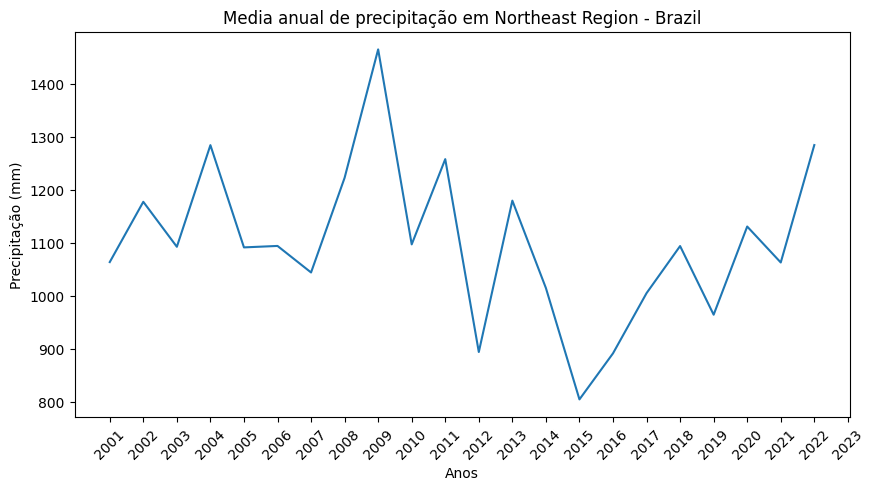

In [67]:
plt.figure(figsize=(10,5))
plt.plot(_dados["Ano"], _dados["Precipitacao"])
plt.xticks(np.arange(_ano_inicial, _ano_final+1, 1), [str(i) for i in range(_ano_inicial, _ano_final+1)], rotation=45)
plt.xlabel('Anos')
plt.ylabel('Precipitação (mm)')
plt.title(f'Media anual de precipitação em {_NomeLocal}')
plt.savefig(_graficos+"precipitacao.png", format="png")
plt.savefig(_graficos+"precipitacao.pdf", format="pdf")
plt.show()

# Pegar agora os dados de evapotranspiração

In [39]:
token_response = requests.post('{}login'.format(api), auth=(user, password)).json()
token = token_response['token']                 
head = {'Authorization': 'Bearer {}'.format(token)}
print(token_response, token)

{'token_type': 'Bearer', 'token': '2Wra49NC6p_I_5ATYD-UhdJlPUXl-DgIQ8wwsZ-Ih-iI_JGqFjBatn1I3gdJIrOXG37RrVaF-iT6Y8d-4wFXnA', 'expiration': '2024-01-28T12:42:23Z'} 2Wra49NC6p_I_5ATYD-UhdJlPUXl-DgIQ8wwsZ-Ih-iI_JGqFjBatn1I3gdJIrOXG37RrVaF-iT6Y8d-4wFXnA


In [40]:
produto_usado = "MOD16A3GF.061"
lst_response = requests.get('{}product/{}'.format(api, produto_usado)).json()
list(lst_response.keys())

['ET_500m', 'ET_QC_500m', 'LE_500m', 'PET_500m', 'PLE_500m']

In [41]:
projections = requests.get('{}spatial/proj'.format(api)).json() 
projs = {}                                  # Create an empty dictionary
for p in projections: projs[p['Name']] = p
projs.keys() 

dict_keys(['native', 'geographic', 'sinu_modis', 'albers_weld_alaska', 'albers_weld_conus', 'albers_ard_alaska', 'albers_ard_conus', 'albers_ard_hawaii', 'easegrid_2_global', 'easegrid_2_north'])

In [42]:
prodLayer = []
bandas_usadas = ['ET_500m',  'PET_500m']
for l in lst_response.keys():
    if l in bandas_usadas:
        prodLayer.append({
                "layer": l,
                "product": produto_usado
              })
prodLayer

[{'layer': 'ET_500m', 'product': 'MOD16A3GF.061'},
 {'layer': 'PET_500m', 'product': 'MOD16A3GF.061'}]

In [43]:
#Configuraçoes de tarefa
task_type = ['point','area']        # Type of task, area or point
proj = projs['geographic']['Name']  # Set output projection 
outFormat = ['geotiff', 'netcdf4']  # Set output file format type
recurring = True                   # Specify True for a recurring date range
yearRange = [_ano_inicial, _ano_final]
task_name = _NomeLocal+" "+str(_ano_inicial)
task = {
        'task_type': task_type[1],
        'task_name': task_name,
        'params': {
             'dates': [
             {
                 'startDate': '01-01',
                 'endDate': '12-31',
                 'yearRange': yearRange,
                 'recurring': recurring
             }],
             'layers': prodLayer,
             'output': {
                     'format': {
                             'type': outFormat[0]}, 
                             'projection': proj},
             'geo': data_Json,
        }
    }
task

{'task_type': 'area',
 'task_name': 'Northeast Region - Brazil 2001',
 'params': {'dates': [{'startDate': '01-01',
    'endDate': '12-31',
    'yearRange': [2001, 2023],
    'recurring': True}],
  'layers': [{'layer': 'ET_500m', 'product': 'MOD16A3GF.061'},
   {'layer': 'PET_500m', 'product': 'MOD16A3GF.061'}],
  'output': {'format': {'type': 'geotiff'}, 'projection': 'geographic'},
  'geo': {'type': 'FeatureCollection',
   'features': [{'type': 'Feature',
     'properties': {},
     'geometry': {'coordinates': [[[-48.798, -1.2080000000000002],
        [-33.798, -1.2080000000000002],
        [-33.798, -16.208],
        [-48.798, -16.208],
        [-48.798, -1.2080000000000002]]],
      'type': 'Polygon'}}]}}}

In [44]:
task_response = ""
_appEEARsDir = _localdataName+"/"+task_name
if not os.path.exists(_appEEARsDir):
    os.makedirs(_appEEARsDir)
    task_response = requests.post('{}task'.format(api), json=task, headers=head).json()
print(task_response)

In [45]:
def status(id_tarefa):
    return requests.get('{}task/{}'.format(api, id_tarefa), headers=head).json()['status']
if task_response != "":
    task_id = task_response['task_id']                                               
    status_response = requests.get('{}status/{}'.format(api, task_id), headers=head).json() 
    print(status_response)
    starttime = time.time()
    intervalo = 20.0
    _status = status(task_id)
    while _status != 'done':
        _status = status(task_id)
        time.sleep(intervalo - ((time.time() - starttime) % intervalo))
        print(_status)
    print(_status)
else:
    print("Os dados já haviam sido baixados")

Os dados já haviam sido baixados


In [46]:
if task_response != "":
    bundle = requests.get('{}bundle/{}'.format(api,task_id), headers=head).json()  # Call API and return bundle contents for the task_id as json
    files = {}                                                       # Create empty dictionary
    for f in bundle['files']: files[f['file_id']] = f['file_name']
    cont = 0
    numero = len(files)
    for f in files:
        if files[f].endswith('.tif'):
            filename = files[f].split('/')[1]
        else:
            filename = files[f] 
        if os.path.exists(_appEEARsDir +"/"+filename):
            cont += 1
        else:
            dl = requests.get('{}bundle/{}/{}'.format(api, task_id, f), headers=head, stream=True, allow_redirects = 'True')
            filepath = os.path.join(_appEEARsDir, filename)                                                      
            with open(filepath, 'wb') as f:                                                                
                for data in dl.iter_content(chunk_size=8192): f.write(data)
            cont += 1
        print(f"Baixando arquivos {cont} / {numero}")
    print('Todos os arquivos da tarefa salvos em: {}'.format(_appEEARsDir))

In [47]:
if os.path.exists(_appEEARsDir +"/MOD16A3GF-061-Statistics.csv"):
    _dataEvapo = pd.read_csv(_appEEARsDir +"/MOD16A3GF-061-Statistics.csv")
_dataEvapo.head()

,File Name,Dataset,aid,Date,Count,Minimum,Maximum,Range,Mean,Standard Deviation,Variance,Upper Quartile,Upper 1.5 IQR,Median,Lower 1.5 IQR,Lower Quartile
0,MOD16A3GF_061_ET_500m_doy2001001_aid0001,ET_500m,aid0001,2001-01-01,9312912,97.5,2841.9,"(97.5,2841.9)",866.462990,377.803943,142735.819638,1098.3,1877.1,781.9,97.5,579.1
1,MOD16A3GF_061_ET_500m_doy2002001_aid0001,ET_500m,aid0001,2002-01-01,9312912,142.6,2680.7,"(142.6,2680.7)",891.964856,363.162318,131886.868984,1116.1,1871.2,806.1,142.6,612.7
2,MOD16A3GF_061_ET_500m_doy2003001_aid0001,ET_500m,aid0001,2003-01-01,9312912,128.4,3006.7,"(128.4,3006.7)",906.869971,365.497180,133588.188907,1120.7,1844.3,838.4,128.4,638.3
3,MOD16A3GF_061_ET_500m_doy2004001_aid0001,ET_500m,aid0001,2004-01-01,9312912,183.0,3221.2,"(183.0,3221.2)",1004.439675,310.192859,96219.609791,1185.5,1793.0,951.5,183.0,780.5
4,MOD16A3GF_061_ET_500m_doy2005001_aid0001,ET_500m,aid0001,2005-01-01,9312912,150.9,2863.2,"(150.9,2863.2)",969.714689,302.909349,91754.073547,1140.9,1718.2,915.0,179.1,756.0


In [48]:
mean_1, mean_2 = np.array_split(_dataEvapo["Mean"], 2)
nova_tabela1 = pd.DataFrame({"ET": mean_1})
nova_tabela2 = pd.DataFrame( {"PET": mean_2.to_list()})
_dados["ET"] = nova_tabela1["ET"]
_dados["PET"] = nova_tabela2["PET"]
#remover linhas invalidas
_dados.dropna(inplace=True)
_dados.head()

C:\Users\bisto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


,Ano,Precipitacao,ET,PET
0,2001,1064.389200,866.462990,2455.659074
1,2002,1177.970682,891.964856,2477.108651
2,2003,1093.212461,906.869971,2432.468774
3,2004,1284.734732,1004.439675,2401.399219
4,2005,1092.075341,969.714689,2403.072296


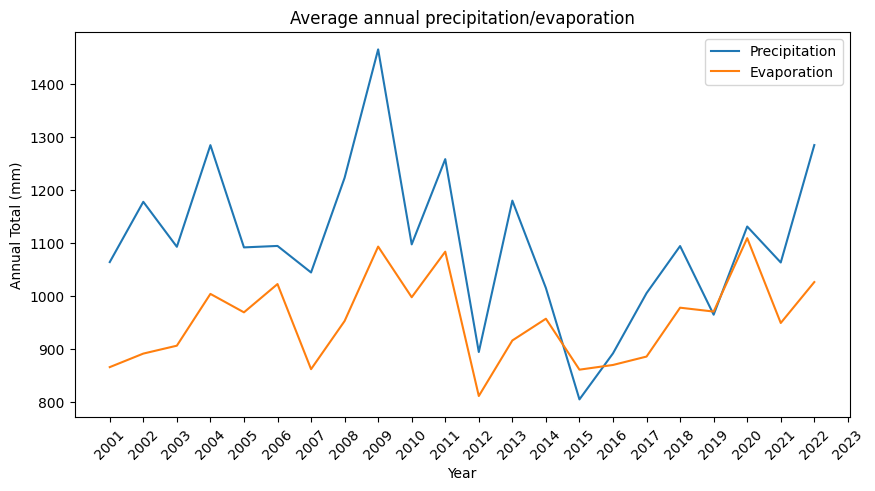

In [68]:
plt.figure(figsize=(10,5))
plt.plot(_dados["Ano"], _dados["Precipitacao"], label="Precipitation")
plt.plot(_dados["Ano"], _dados["ET"], label="Evaporation")
plt.xticks(np.arange(_ano_inicial, _ano_final+1, 1), [str(i) for i in range(_ano_inicial, _ano_final+1)],  rotation=45)
plt.xlabel('Year')
plt.ylabel('Annual Total (mm)')
plt.title(f'Average annual precipitation/evaporation')
plt.legend()
plt.savefig(_graficos+"precipitacao e evaporacao.png", format="png")
plt.savefig(_graficos+"precipitacao e evaporacao.pdf", format="pdf")
plt.show()

In [50]:
_dados['Indice de Aridez UNEP'] = _dados["Precipitacao"] / _dados["PET"]
_dados['Aridez'] = _dados["Precipitacao"] / _dados["ET"]
_dados.head()

,Ano,Precipitacao,ET,PET,Indice de Aridez UNEP,Aridez
0,2001,1064.389200,866.462990,2455.659074,0.433443,1.228430
1,2002,1177.970682,891.964856,2477.108651,0.475543,1.320647
2,2003,1093.212461,906.869971,2432.468774,0.449425,1.205479
3,2004,1284.734732,1004.439675,2401.399219,0.534994,1.279056
4,2005,1092.075341,969.714689,2403.072296,0.454450,1.126182


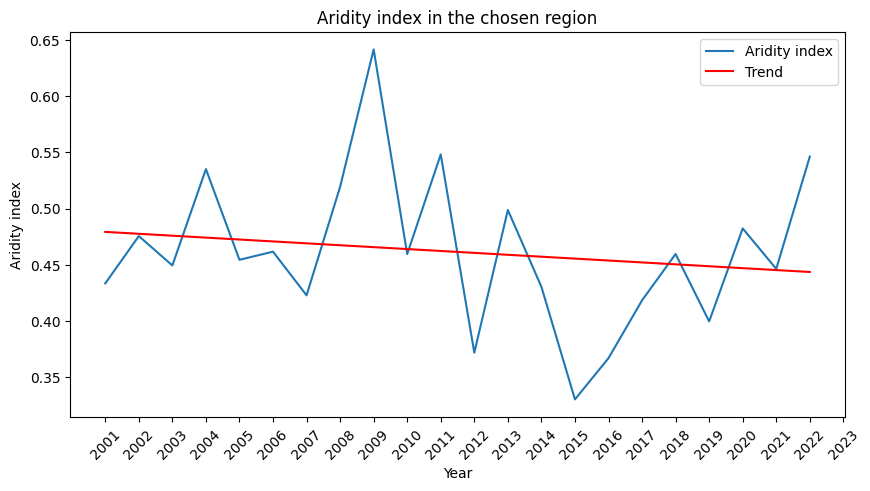

In [69]:
z = np.polyfit(_dados["Ano"], _dados["Indice de Aridez UNEP"], 1)
p = np.poly1d(z) # Criando um objeto polinomial
plt.figure(figsize=(10,5))
plt.plot(_dados["Ano"], _dados["Indice de Aridez UNEP"],label="Aridity index")
plt.plot(_dados["Ano"], p(_dados["Ano"]), 'r-',label="Trend")
plt.xticks(np.arange(_ano_inicial, _ano_final+1, 1), [str(i) for i in range(_ano_inicial, _ano_final+1)], rotation=45)
plt.xlabel('Year')
plt.ylabel('Aridity index')
plt.title(f'Aridity index in the chosen region')
plt.legend()
plt.savefig(_graficos+"IA.png", format="png")
plt.savefig(_graficos+"IA.pdf", format="pdf")
plt.show()

# calculando resultados

In [52]:
def categoria_climatica(index):
    if index >= 0.65:
        return 'Humid'
    elif index >= 0.5:
        return 'Subhumid'
    elif index >= 0.2:
        return 'Semiarid'
    elif index >= 0.05:
        return 'Arid'
    else:
        return 'Hyperarid'
def risco_desertificacao(ai):
  if ai < 0.05:
    return "Above Very High (AVH)"
  elif 0.05 <= ai <= 0.20:
    return "Very High (VH)"
  elif 0.21 <= ai <= 0.50:
    return "High (H)"
  elif 0.51 <= ai <= 0.65:
    return "Moderate (M)"
  else:
    return "Low (L)"
_IndiceAridez = _dados['Indice de Aridez UNEP'].mean()
_Aridez = _dados['Indice de Aridez UNEP'].mean()
_AriderN = (p(_dados["Ano"])).mean()
aridez = _dados.iloc[-1]['Indice de Aridez UNEP']
print(f"Essa região está classificada atualmente como sendo uma região {aridez:.2f}, o que lhe classifica como uma região {categoria_climatica(aridez)}")
print(f"Entre os anos de {_ano_inicial } e {_ano_final}, a região teve um indice medio de {_AriderN:.2f}, o que lhe classifica como uma região {categoria_climatica(_AriderN)}")
print(f"A chance de desertificação da região está classificada como {risco_desertificacao(_AriderN)}")
#if a < 0:
#    print("Foi observado um processo de diminuição do total de chuva em relação ao total de evaporação")

Essa região está classificada atualmente como sendo uma região 0.55, o que lhe classifica como uma região Subhumid
Entre os anos de 2001 e 2023, a região teve um indice medio de 0.46, o que lhe classifica como uma região Semiarid
A chance de desertificação da região está classificada como High (H)


In [53]:
_dados["Aridez2"] = _dados["ET"] / _dados["PET"]
_Aridez2 = _dados['Aridez2'].mean()
print(f"Comparando os 2 indices para verificar equivalencia {_Aridez:.2f} ~= {_Aridez2:.2f}")

Comparando os 2 indices para verificar equivalencia 0.46 ~= 0.40


In [54]:
nomes = os.listdir(_appEEARsDir) 
_arquivos = [nome for nome in nomes if os.path.isfile(os.path.join(_appEEARsDir, nome))] 

In [70]:
_bounds = 0
def mostraGraficoDoAno(ano):
    for f in _arquivos:
        nome = f#_arquivos[f]
        if "_ET_5" in nome and f"doy{ano}" in nome:
            et_tif = nome
        if "_PET_5" in nome and f"doy{ano}" in nome:
            pet_tif = nome
    et_tif = _appEEARsDir+"/"+et_tif
    pet_tif = _appEEARsDir+"/"+pet_tif
    with rasterio.open(et_tif) as et:
      et_data = et.read(1) 
    with rasterio.open(pet_tif) as pet:
      pet_data = pet.read(1) 
    arid_data = et_data / pet_data
    return arid_data
_mascara = 1
def PlotGrafico(data, name = '' ):
    plt.title(f'{_NomeLocal}' + name)
    plt.imshow(data, cmap='jet_r', vmin=0, vmax=1)
    plt.colorbar(label='Aridez')
    mascara = np.where(data < 0.2, 0, np.nan)
    _mascara = mascara
    plt.imshow(mascara, cmap='gray', vmin=0, vmax=1, alpha=1)
    branco = np.where(data == 1, 0, np.nan)
    plt.imshow(branco, cmap='gray_r', vmin=0, vmax=1, alpha=1)
    plt.axis('off')
    plt.savefig(_graficos+f"mapa IA {name}.png", format="png")
    plt.savefig(_graficos+f"mapa IA {name}.pdf", format="pdf")
    plt.show()
#PlotGrafico(mostraGraficoDoAno(_ano_final-1))

In [56]:
_dado = []
for i in range(_ano_inicial,_ano_final,2):
    _dado.append(mostraGraficoDoAno(i))
_final = np.mean(_dado, axis=0)

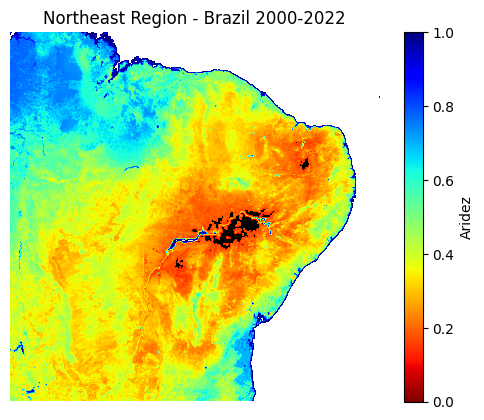

In [71]:
PlotGrafico(_final," 2000-2022")

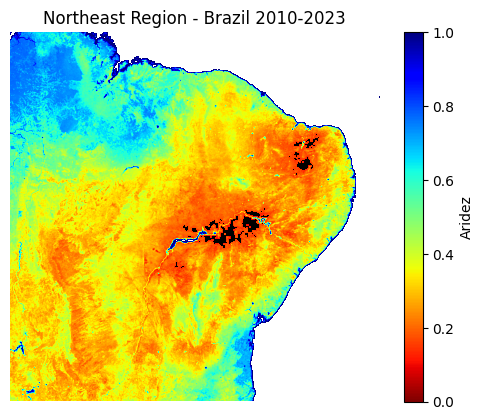

In [78]:
_dado2 = []
t = len(range(_ano_inicial,_ano_final,2))
intervalo = int(t/2)
for i in range(_ano_inicial, _ano_inicial + intervalo ,2):
    _dado2.append(mostraGraficoDoAno(i))
_inicial = np.mean(_dado2, axis=0)
PlotGrafico(_inicial, " 2010-2023")

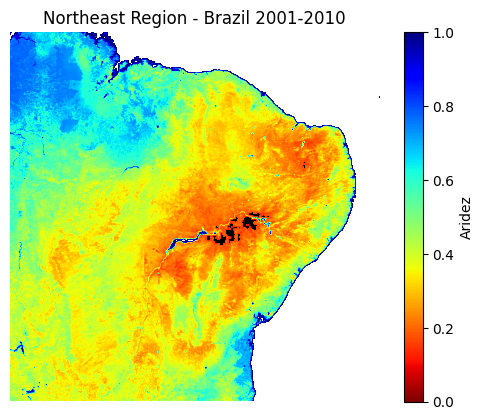

In [77]:
_dado2 = []
t = len(range(_ano_inicial,_ano_final,2))
intervalo = int(t/2)
for i in range(_ano_inicial+ intervalo, _ano_final ,2):
    _dado2.append(mostraGraficoDoAno(i))
_inicial = np.mean(_dado2, axis=0)
PlotGrafico(_inicial, " 2001-2010")

# RAI

In [59]:
def rai(precipitacao, media, desvio):
    return (precipitacao - media) / desvio * 100
# Calcula a media e o desvio da coluna Precipitacao
media = _dados['Precipitacao'].mean()
desvio = _dados['Precipitacao'].std()

# Cria uma nova coluna RAI aplicando a funcao rai a cada valor da coluna Precipitacao
_dados['RAI'] = _dados['Precipitacao'].apply(rai, args=(media, desvio))
_dados.head()

,Ano,Precipitacao,ET,PET,Indice de Aridez UNEP,Aridez,Aridez2,RAI
0,2001,1064.389200,866.462990,2455.659074,0.433443,1.228430,0.352843,-24.816860
1,2002,1177.970682,891.964856,2477.108651,0.475543,1.320647,0.360083,51.340179
2,2003,1093.212461,906.869971,2432.468774,0.449425,1.205479,0.372819,-5.490697
3,2004,1284.734732,1004.439675,2401.399219,0.534994,1.279056,0.418273,122.926091
4,2005,1092.075341,969.714689,2403.072296,0.454450,1.126182,0.403531,-6.253143


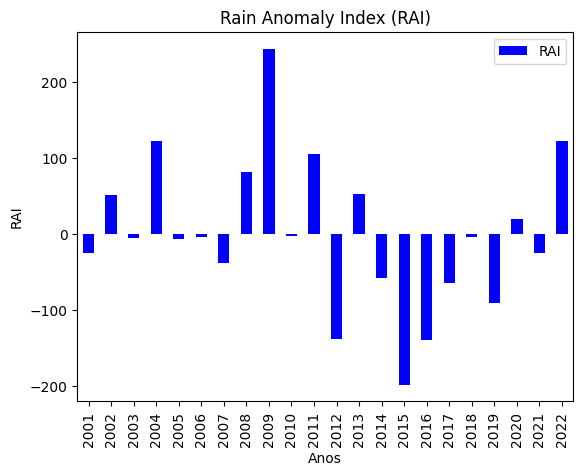

In [73]:
_dados.plot(kind='bar', x='Ano', y='RAI', title='Rain Anomaly Index (RAI)', xlabel='Anos', ylabel='RAI', color='blue')
plt.savefig(_graficos+"RAI.png", format="png")
plt.savefig(_graficos+"RAI.pdf", format="pdf")
plt.show()

Visualização das informações

In [61]:
# Ler a imagem tiff
img = rasterio.open(_appEEARsDir+"/MOD16A3GF.061_ET_500m_doy2001001_aid0001.tif")
imagem = 1-_final
#imagem = np.where(_final < 0.15, 0, 1)
bound = img.bounds
#imagem = np.where(_final < 0.15, 0, 1)
#imagem_rotacionada = rotate (imagem, angle=0, preserve_range=True)
#imagem = 1-imagem_rotacionada

left, right, bottom, top = bound.left, bound.right, bound.bottom, bound.top
m = folium.Map(location=[(top+bottom)/2, (left+right)/2], zoom_start=5)
folium.GeoJson(geo_json_data).add_to(m)
x = 0.07#.5
y = 0#-1.5

In [62]:
def funcCor(x):
    if x == 0:
        return (0, 0, 0, 0)
    else:
        return (x, 0, 1-x, 1)

#image = folium.raster_layers.ImageOverlay(
#    name="Evapotranspiração",
#    image=imagem,#img.read(1),
#    bounds=[[bottom+x, left+y], [top+x, right+y]],
#    colormap=funcCor,
#    opacity=0.3,
#    interactive=True,
#    zindex=1
#)
#image.add_to(m)

In [63]:
#Area de perigo
imagem = np.where(_final < 0.15, 0, 1)
imagem = 1 - imagem
imag = folium.raster_layers.ImageOverlay(
    name="perigo",
    image=imagem,#img.read(1),
    bounds=[[bottom+x, left+y], [top+x, right+y]],
    colormap=lambda x: (0, 0, 0, x),
    opacity=.7,
    interactive=True,
    zindex=1
)
imag.add_to(m)


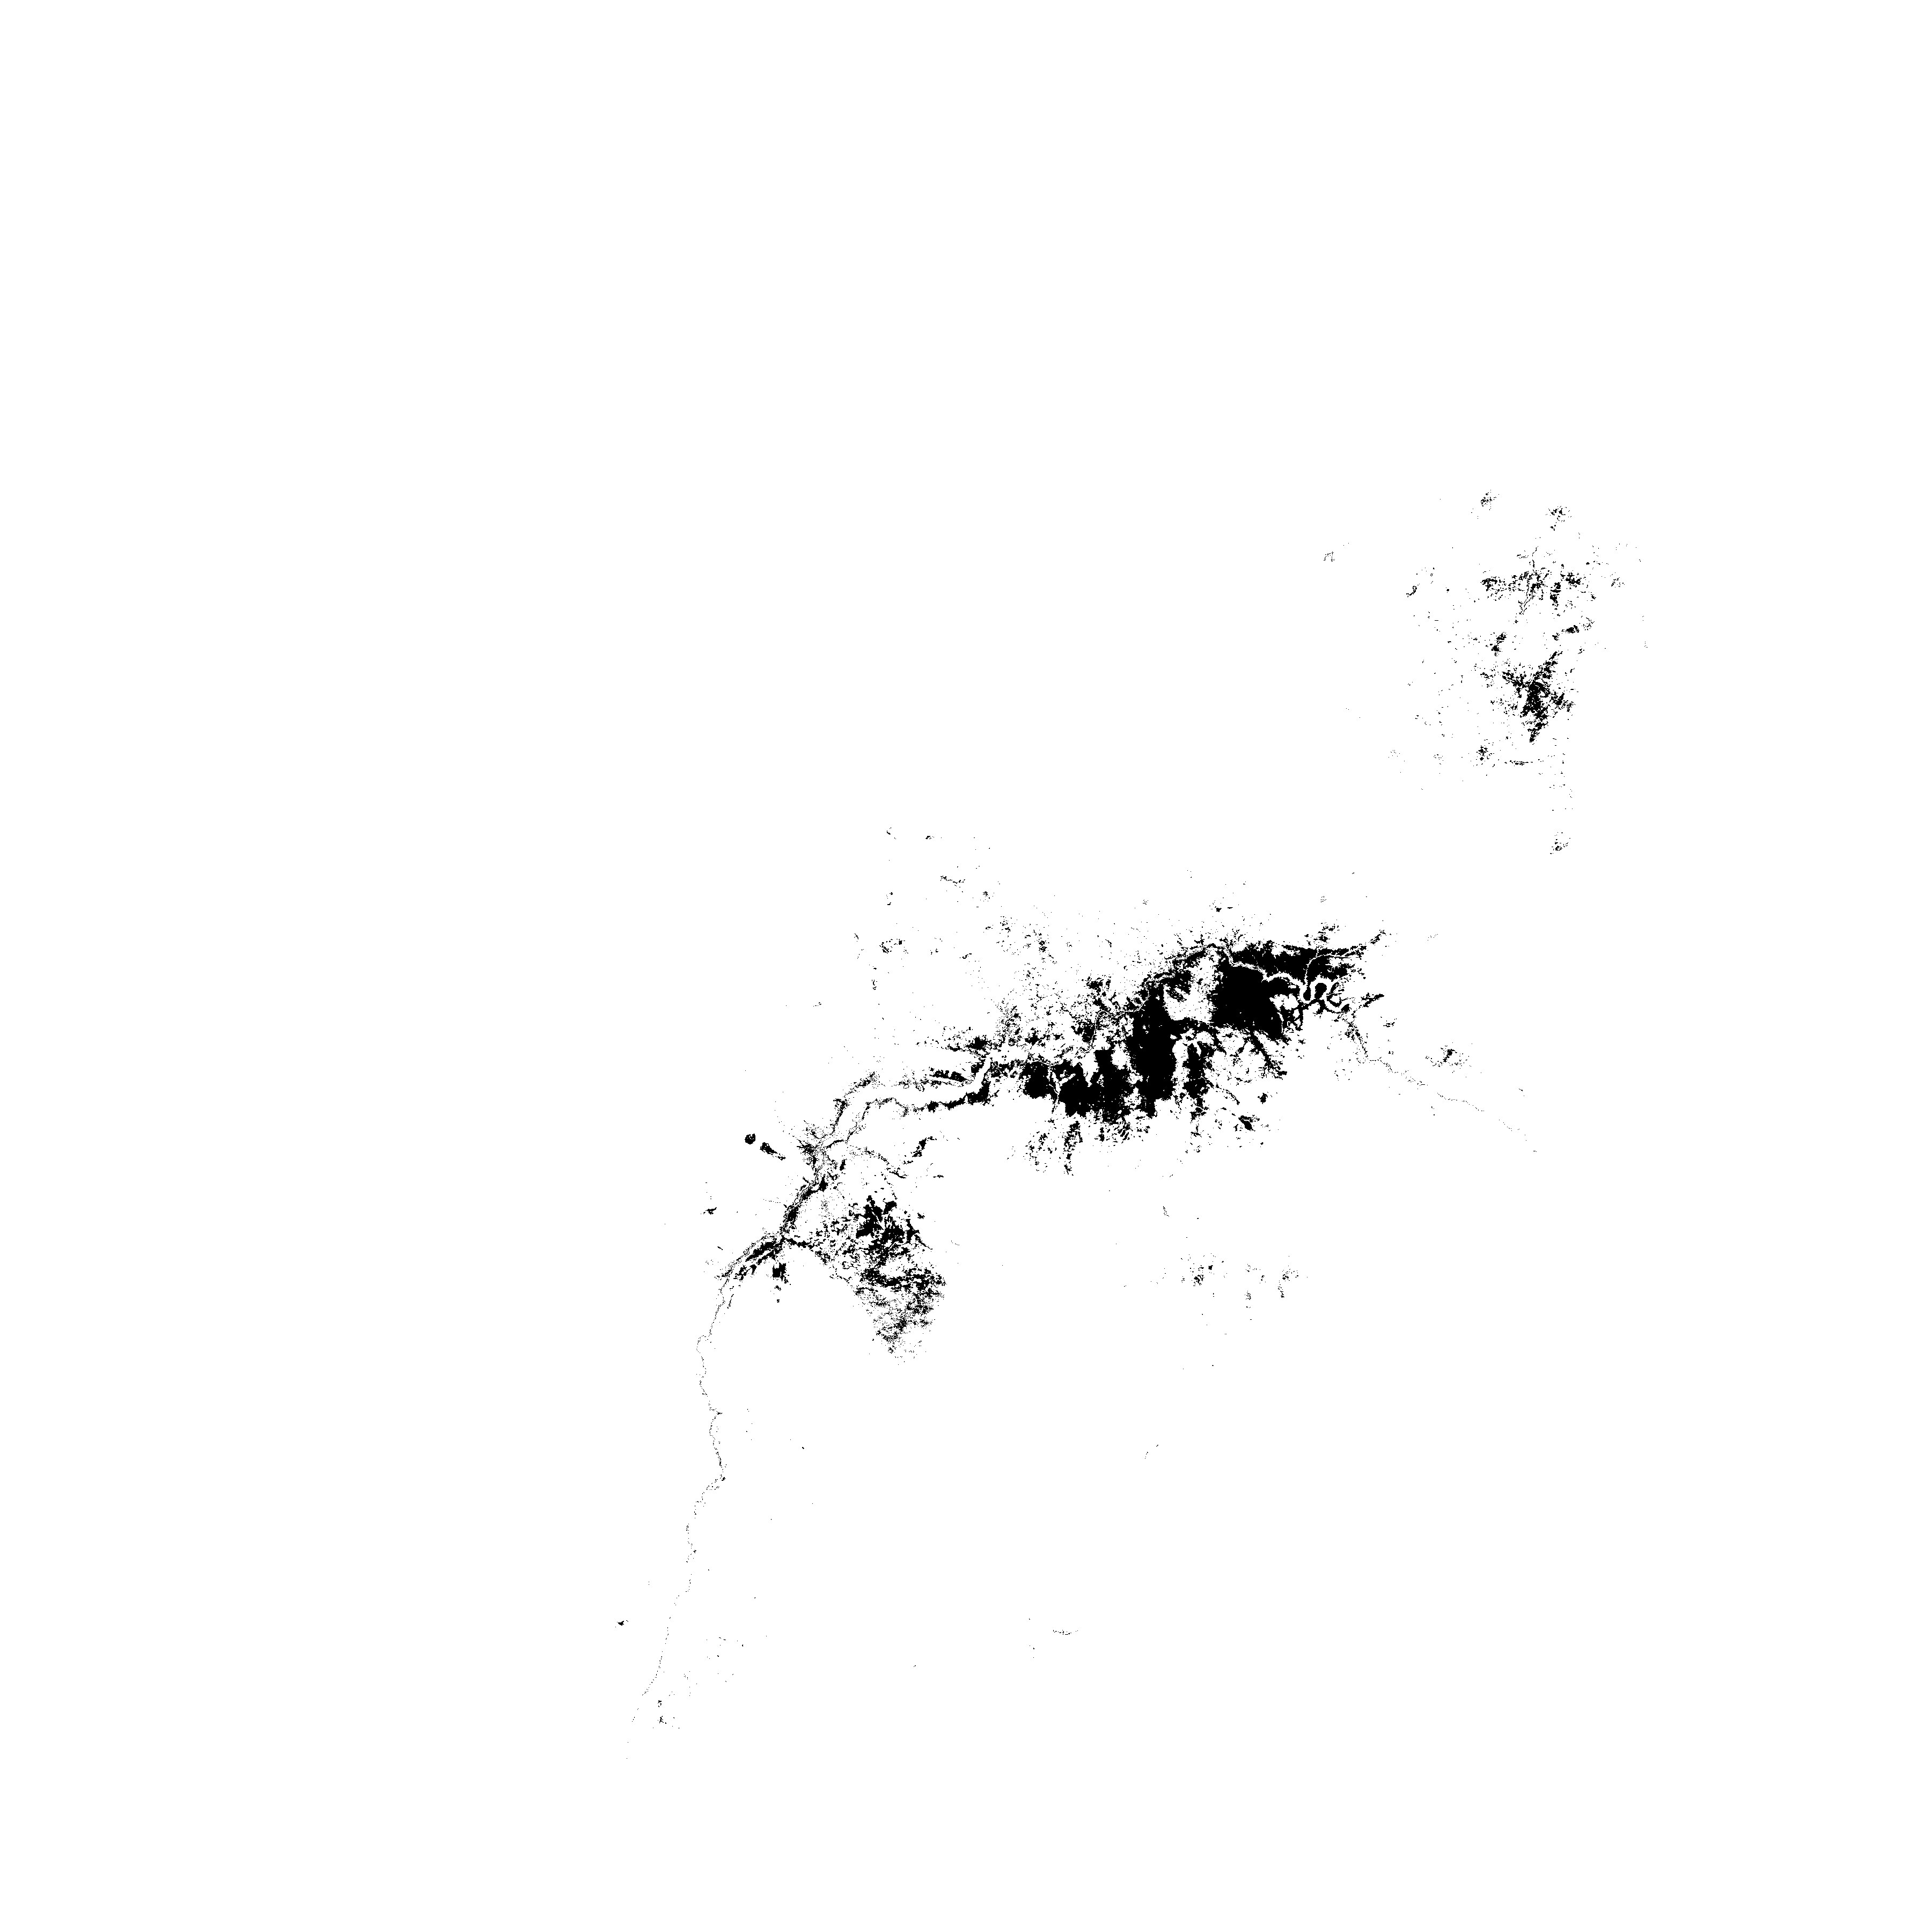

In [64]:
#Exibir grafico
m.save(_graficos+"map final.html")
m

In [65]:
# adicionar o texto informativo abaixo de tudo
aridez = _dados.iloc[-1]['Indice de Aridez UNEP']
_txt1 = f"This region is currently classified as a region {aridez:.2f}, which classifies it as a region {categoria_climatica(aridez)}" 
_txt2 = f"Between the years of {_ano_inicial } and {_ano_final}, the region had an average index of {_AriderN:.2f}, which classifies it as a region {categoria_climatica(_AriderN)}" 
_txt3 = f"The chance of desertification of the region is classified as {risco_desertificacao(_AriderN)}"

# Criar a visualização

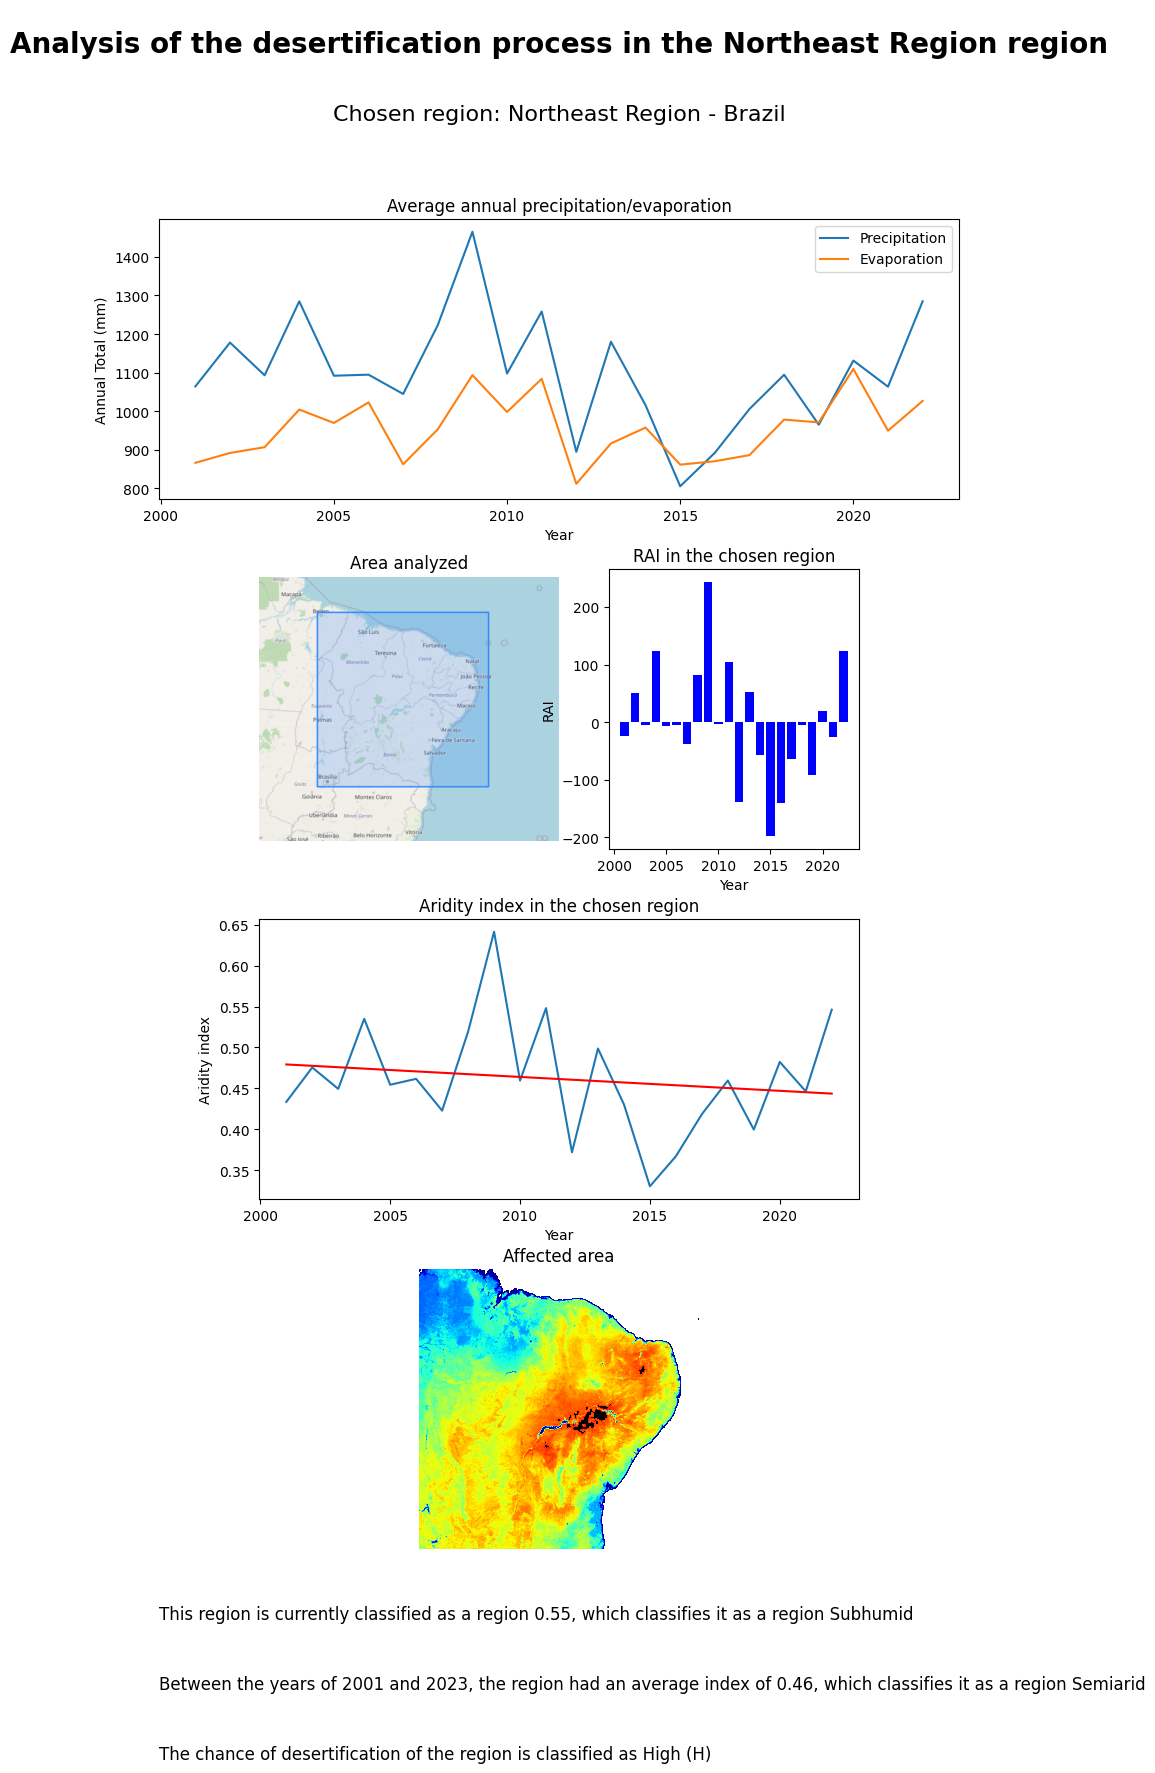

In [74]:
import matplotlib.image as mpimg # importar módulo para ler imagens

# definir o título e o subtítulo da imagem
titulo = "Analysis of the desertification process in the Northeast Region region"
subtitulo = f"Chosen region: {_NomeLocal}"

# criar uma figura com tamanho adequado
fig = plt.figure(figsize=(10, 14))

# adicionar um eixo para o título
ax1 = fig.add_axes([0, 0.95, 1, 0.05])
ax1.set_axis_off() # remover os eixos
ax1.text(0.5, 0.5, titulo, fontsize=20, fontweight='bold', ha='center', va='center') # adicionar o texto do título

# adicionar um eixo para o subtítulo
ax2 = fig.add_axes([0, 0.9, 1, 0.05])
ax2.set_axis_off() # remover os eixos
ax2.text(0.5, 0.5, subtitulo, fontsize=16, ha='center', va='center') # adicionar o texto do subtítulo

# adicionar um eixo para o gráfico
ax3 = fig.add_axes([0.1, 0.65, 0.8, 0.2])

# gerar alguns dados fictícios para o gráfico
# você pode substituir esses dados pelos seus dados reais
# plotar o gráfico de linha
ax3.plot(_dados["Ano"], _dados["Precipitacao"], label="Precipitation")
ax3.plot(_dados["Ano"], _dados["ET"], label="Evaporation")
ax3.set_xlabel('Year') # definir o rótulo do eixo x
ax3.set_ylabel('Annual Total (mm)') # definir o rótulo do eixo y
ax3.set_title(f'Average annual precipitation/evaporation') # definir o título do gráfico
#ax3.xticks(np.arange(_ano_inicial, _ano_final+1, 1), [str(i) for i in range(_ano_inicial, _ano_final+1)],  rotation=45)
ax3.legend()

# adicionar um eixo para a imagem da área analisada
ax4 = fig.add_axes([0.2, 0.4, 0.3, 0.2])
ax4.set_axis_off() # remover os eixos
ax4.set_title('Area analyzed') # definir o título da imagem

# ler a imagem salva em arquivo
mapa = mpimg.imread(_graficos+"mapRegiao.png")

# mostrar a imagem da área analisada
ax4.imshow(mapa)

# adicionar um eixo para o gráfico de barras
ax5 = fig.add_axes([0.55, 0.4, 0.25, 0.2])

# usar os dados da tabela para o gráfico de barras
anos = _dados['Ano']
rai = _dados['RAI']

# plotar o gráfico de barras
ax5.bar(anos, rai, color='blue')
ax5.set_xlabel('Year') # definir o rótulo do eixo x
ax5.set_ylabel('RAI') # definir o rótulo do eixo y
ax5.set_title('RAI in the chosen region') # definir o título do gráfico

# adicionar um eixo para o gráfico de índice de aridez
ax6 = fig.add_axes([0.2, 0.15, 0.6, 0.2])

# gerar alguns dados fictícios para o gráfico de índice de aridez
# você pode substituir esses dados pelos seus dados reais
aridez = _dados["Indice de Aridez UNEP"]
z = np.polyfit(_dados["Ano"], _dados["Indice de Aridez UNEP"], 1)
p = np.poly1d(z) # Criando um objeto polinomial
# plotar o gráfico de linha
ax6.plot(anos, aridez)
ax6.plot(_dados["Ano"], p(_dados["Ano"]), 'r-',label="Tendencia")
ax6.set_xlabel('Year') # definir o rótulo do eixo x
ax6.set_ylabel('Aridity index') # definir o rótulo do eixo y
ax6.set_title('Aridity index in the chosen region') # definir o título do gráfico

# adicionar um eixo para o gráfico de região afetada
ax7 = fig.add_axes([0.2, -0.1, 0.6, 0.2])

# gerar alguns dados fictícios para o gráfico de região afetada
# você pode substituir esses dados pelos seus dados reais
ax7.imshow(_final, cmap='jet_r', vmin=0, vmax=1)
mascara = np.where(_final < 0.2, 0, np.nan)
ax7.imshow(mascara, cmap='gray', vmin=0, vmax=1, alpha=1)
branco = np.where(_final == 1, 0, np.nan)
ax7.imshow(branco, cmap='gray_r', vmin=0, vmax=1, alpha=1)
ax7.axis('off')
ax7.set_title('Affected area')
#ax7.colorbar(label='Aridez')

#fig.colorbar(ax7, ax=ax7, label='Aridez', orientation='horizontal')

# adicionar o texto informativo abaixo de tudo
fig.text(0.1, -0.15, _txt1, fontsize=12)
fig.text(0.1, -0.2, _txt2, fontsize=12)
fig.text(0.1, -0.25, _txt3, fontsize=12)


#ax8 = fig.add_axes([0.2, -0.1, 0.6, 0.2])
# ajustar o espaçamento entre os eixos
#fig.subplots_adjust(hspace=0.7, wspace=0.5)

# salvar a figura como um arquivo png
plt.savefig('visualizacao.png')
plt.savefig('visualizacao.pdf')